<a href="https://colab.research.google.com/github/Hesham-Elwakeel/Deep-Learnign-Projeacts/blob/main/Skin-Cancer-Detection/Skin_Cancer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import libraries

import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/My Drive/Projects"
print(os.listdir(path))

['HAM10000']


In [6]:
DATA_DIR = "/content/drive/MyDrive/Projects/HAM10000"

In [7]:
data_dir = '/content/drive/MyDrive/Projects/HAM10000'
metadata_path = '/content/drive/MyDrive/Projects/HAM10000/HAM10000_metadata.csv'

print("Number of images:", len(os.listdir(data_dir)))

Number of images: 3


In [8]:
meta_path = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
images_dir = os.path.join(DATA_DIR, "Images")

print("Metadata exists:", os.path.exists(meta_path))
print("Images folder exists:", os.path.exists(images_dir))
print("Data dir:", DATA_DIR)

meta_path = os.path.join(DATA_DIR, "HAM10000_metadata.csv")

Metadata exists: True
Images folder exists: True
Data dir: /content/drive/MyDrive/Projects/HAM10000


# قراءة الـ CSV واستكشاف سريع

In [9]:
# load metadata CSV and quick exploration
df = pd.read_csv(meta_path)
print("Rows:", len(df))
display(df.head())
display(df['dx'].value_counts())


Rows: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


#Create full image path column and drop missing images

In [10]:
# map image_id to actual file path and drop missing rows if any

def find_image_path(img_id, images_dir=images_dir):
    for ext in ('.jpg', '.jpeg', '.png'):
        p = os.path.join(images_dir, img_id + ext)
        if os.path.exists(p):
            return p
    # fallback: try as-is (maybe images are located directly)
    return os.path.join(images_dir, img_id + '.jpg')

df['image_path'] = df['image_id'].apply(lambda x: find_image_path(x))
missing = df[~df['image_path'].map(os.path.exists)]
print("Missing images count:", len(missing))
if len(missing) > 0:
    display(missing.head())
# keep only existing
df = df[df['image_path'].map(os.path.exists)].reset_index(drop=True)
print("Remaining rows after dropping missing:", len(df))



Missing images count: 0
Remaining rows after dropping missing: 10015


# Create label index and label mapping (name to index)

In [11]:
df['label'] = df['dx']  # use dx column as label name
label_names = sorted(df['label'].unique().tolist())   # sorted list of label strings
label_to_index = {lab: i for i, lab in enumerate(label_names)}
df['label_idx'] = df['label'].map(label_to_index)

print("Labels:", label_names)
print("Mapping:", label_to_index)

Labels: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


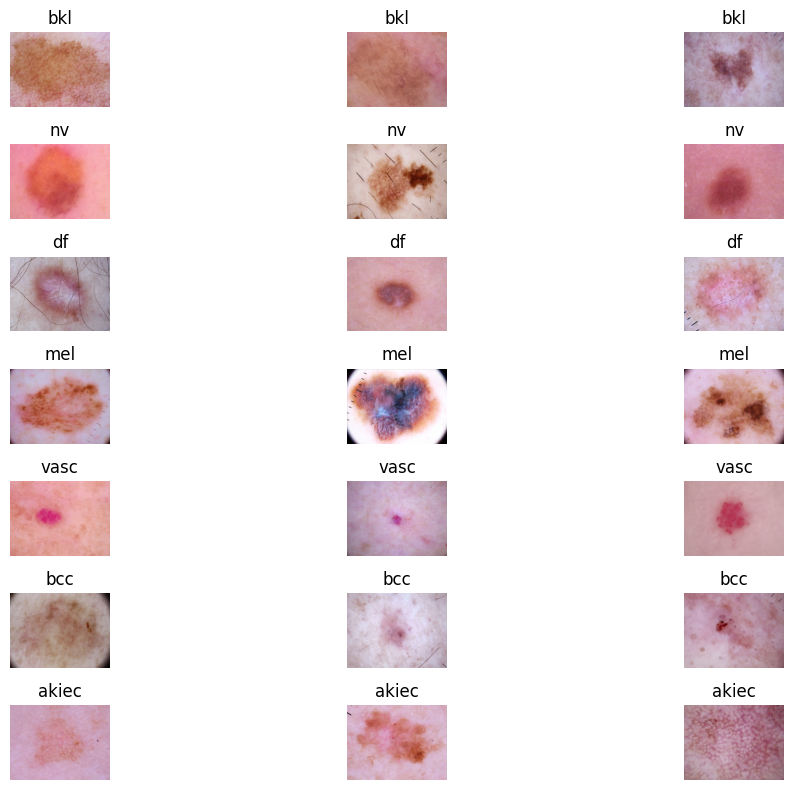

In [12]:
import matplotlib.image as mpimg

# عدد الصور اللي هنعرضها من كل فئة
num_samples_per_class = 3

# المسار اللي فيه الصور
image_dir = os.path.join(DATA_DIR, "Images")

# نجيب أسماء الفئات
classes = df['label'].unique()

# نحدد حجم الشكل العام
plt.figure(figsize=(12, 8))

i = 1
for cls in classes:
    # نجيب كل الصور اللي بتنتمي للفئة دي
    subset = df[df['label'] == cls]

    # نختار عشوائيًا بعض الصور منها
    sample_images = subset.sample(num_samples_per_class, random_state=42)

    for idx, row in sample_images.iterrows():
        img_path = os.path.join(image_dir, row['image_id'] + ".jpg")

        # نعرض الصورة
        plt.subplot(len(classes), num_samples_per_class, i)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls)
        i += 1

plt.tight_layout()
plt.show()


In [13]:
#Stratified split into train / validation / test sets
#Stratified keeps the same label distribution across all sets (important for balanced classes)
train_df, test_df = train_test_split(df,
                                     test_size=0.20,
                                     stratify=df['label_idx'], # Ensure proportional label distribution (stratified)
                                     random_state=42)

train_df, val_df = train_test_split(train_df,
                                    test_size=0.125,
                                    stratify=train_df['label_idx'],
                                    random_state=42)
# split ratio ≈ 70% train / 10% validation / 20% test

print("Sizes => train / val / test:", len(train_df), len(val_df), len(test_df))
display(train_df['label'].value_counts())

Sizes => train / val / test: 7010 1002 2003


,count
label,
nv,4693
mel,779
bkl,769
bcc,360
akiec,229
vasc,100
df,80


# Compute class weights (to help training with imbalanced classes)

In [14]:
classes = np.unique(train_df['label_idx'])
# automatically calculate a balanced weight for each class
class_weights_arr = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['label_idx'])
# Convert the array of weights into a dictionary {class_index: weight_value}
class_weights = {int(i): float(w) for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

Class weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.517857142857142, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.014285714285714}


# ImageDataGenerator and flow_from_dataframe

In [15]:
#augmentation for training and simple rescale for val/test

IMG_SIZE = 224
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_flow = val_test_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_flow = val_test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 7010 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


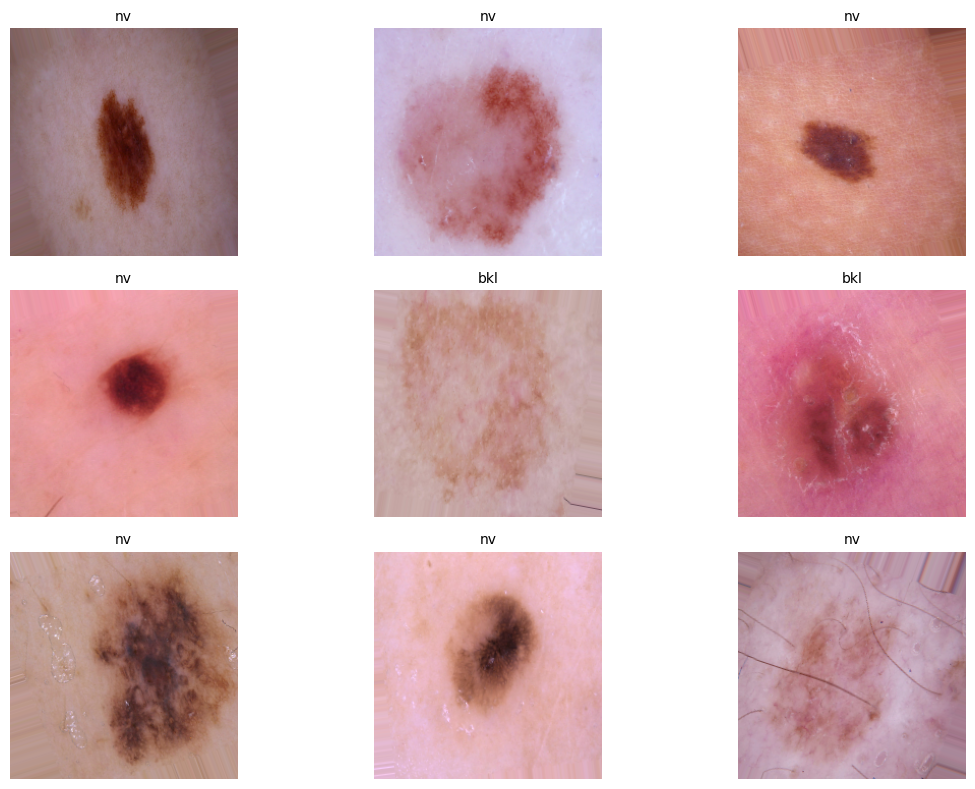

In [16]:
#some augmented training images
sample_batch = next(train_flow)   # Get one batch of augmented images
images, labels = sample_batch     # Separate images and labels

# Reverse from index to label name
index_to_label = {v: k for k, v in label_to_index.items()}

plt.figure(figsize=(12, 8))

for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    # Get the class name from one-hot encoded label
    label_idx = np.argmax(labels[i])
    label_name = index_to_label[label_idx]

    plt.title(label_name, fontsize=10)

plt.tight_layout()
plt.show()


#Build model (EfficientNetB0 backbone + small head)

In [17]:
# use EfficientNetB0 pretrained on ImageNet and attach a classification head

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # freeze backbone initially

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Compile model and prepare callbacks

In [18]:
#Compile the model and set up callbacks (Checkpoint, ReduceLR, EarlyStopping)

LR = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = os.path.join(DATA_DIR, 'best_effnetb0.h5')
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train the top head first

In [19]:
# train the new head for a few epochs before fine-tuning the backbone

epochs_head = 6
history_head = model.fit(
    train_flow,
    validation_data = val_flow,
    epochs = epochs_head,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1042 - loss: 1.9487
Epoch 1: val_loss improved from inf to 1.94635, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 2020s 9s/step - accuracy: 0.1041 - loss: 1.9489 - val_accuracy: 0.0509 - val_loss: 1.9464 - learning_rate: 0.0010
Epoch 2/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0314 - loss: 1.9709
Epoch 2: val_loss did not improve from 1.94635
220/220 ━━━━━━━━━━━━━━━━━━━━ 788s 4s/step - accuracy: 0.0314 - loss: 1.9708 - val_accuracy: 0.0509 - val_loss: 1.9496 - learning_rate: 0.0010
Epoch 3/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0357 - loss: 1.9238
Epoch 3: val_loss did not improve from 1.94635
220/220 ━━━━━━━━━━━━━━━━━━━━ 831s 4s/step - accuracy: 0.0358 - loss: 1.9239 - val_accuracy: 0.0509 - val_loss: 1.9498 - learning_rate: 0.0010
Epoch 4/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0148 - loss: 1.9716
Epoch 4: val_loss did not improve from 1.94635

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
220/220 ━━━━━━━━━━━━━━━━━━━━ 836s 4s/step - accuracy: 0.0148 - loss: 1.9715 - val_accuracy: 0.0509 - va

220/220 ━━━━━━━━━━━━━━━━━━━━ 813s 4s/step - accuracy: 0.0260 - loss: 2.0110 - val_accuracy: 0.0509 - val_loss: 1.9459 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 6.


#Fine-tuning - unfreeze last layers and continue training

In [ ]:
base_model.trainable = True

# freeze early layers to avoid destroying low-level features (example: freeze first N layers)
freeze_until = 200   # كقيمة افتراضية
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_TUNE = 10
history_ft = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS_TUNE,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.1280 - loss: 2.0611
Epoch 1: val_loss improved from 1.93012 to 1.91809, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 211s 822ms/step - accuracy: 0.1281 - loss: 2.0608 - val_accuracy: 0.6697 - val_loss: 1.9181 - learning_rate: 1.0000e-05
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.1851 - loss: 1.9877
Epoch 2: val_loss did not improve from 1.91809
220/220 ━━━━━━━━━━━━━━━━━━━━ 151s 688ms/step - accuracy: 0.1851 - loss: 1.9876 - val_accuracy: 0.5499 - val_loss: 1.9421 - learning_rate: 1.0000e-05
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.1914 - loss: 1.9650
Epoch 3: val_loss did not improve from 1.91809
220/220 ━━━━━━━━━━━━━━━━━━━━ 151s 686ms/step - accuracy: 0.1914 - loss: 1.9650 - val_accuracy: 0.1108 - val_loss: 1.9453 - learning_rate: 1.0000e-05
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.1973 - loss: 1.9604
Epoch 4: val_loss did not improve from 1.91809

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
220/220 ━━━━━━━━━━━━━━━━━━━━ 204s 698ms/step - accuracy: 0.1973 - loss:

Load best checkpoint and evaluate on test set

In [ ]:
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(test_flow)
print(f"Test Loss: {loss:.4f} | Test Acc: {acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 647s 10s/step - accuracy: 0.6568 - loss: 1.9189
Test Loss: 1.9181 | Test Acc: 66.95%


In [20]:

base_model.trainable = True

for layer in base_model.layers[:20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable layers: {np.sum([layer.trainable for layer in base_model.layers])}")

EPOCHS_FINE = 15

history_fine = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=callbacks
)


#test_loss, test_acc = model.evaluate(test_flow)
#print(f"Fine-tuned Model → Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc * 100:.2f}%")


Total layers: 238
Trainable layers: 218
Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0709 - loss: 2.3390
Epoch 1: val_loss did not improve from 1.94587
220/220 ━━━━━━━━━━━━━━━━━━━━ 1918s 8s/step - accuracy: 0.0710 - loss: 2.3384 - val_accuracy: 0.1018 - val_loss: 2.2763 - learning_rate: 1.0000e-05
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1175 - loss: 1.9120
Epoch 2: val_loss did not improve from 1.94587
220/220 ━━━━━━━━━━━━━━━━━━━━ 1886s 9s/step - accuracy: 0.1176 - loss: 1.9120 - val_accuracy: 0.0928 - val_loss: 3.6913 - learning_rate: 1.0000e-05
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2100 - loss: 1.8277
Epoch 3: val_loss did not improve from 1.94587
220/220 ━━━━━━━━━━━━━━━━━━━━ 1952s 9s/step - accuracy: 0.2101 - loss: 1.8272 - val_accuracy: 0.1008 - val_loss: 4.9374 - learning_rate: 1.0000e-05
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3142 - loss: 1.5870
Epoch 4: val_loss improved from 1.9458

220/220 ━━━━━━━━━━━━━━━━━━━━ 1886s 9s/step - accuracy: 0.3143 - loss: 1.5870 - val_accuracy: 0.4631 - val_loss: 1.5776 - learning_rate: 1.0000e-05
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3868 - loss: 1.4652
Epoch 5: val_loss improved from 1.57760 to 1.47354, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1876s 9s/step - accuracy: 0.3868 - loss: 1.4652 - val_accuracy: 0.4760 - val_loss: 1.4735 - learning_rate: 1.0000e-05
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4336 - loss: 1.4520
Epoch 6: val_loss improved from 1.47354 to 1.33605, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1894s 9s/step - accuracy: 0.4337 - loss: 1.4518 - val_accuracy: 0.5409 - val_loss: 1.3360 - learning_rate: 1.0000e-05
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4601 - loss: 1.4163
Epoch 7: val_loss improved from 1.33605 to 1.30879, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1889s 9s/step - accuracy: 0.4602 - loss: 1.4159 - val_accuracy: 0.5359 - val_loss: 1.3088 - learning_rate: 1.0000e-05
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4976 - loss: 1.2662
Epoch 8: val_loss improved from 1.30879 to 1.20560, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1944s 9s/step - accuracy: 0.4976 - loss: 1.2664 - val_accuracy: 0.5838 - val_loss: 1.2056 - learning_rate: 1.0000e-05
Epoch 9/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5130 - loss: 1.2527
Epoch 9: val_loss improved from 1.20560 to 1.18797, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1953s 9s/step - accuracy: 0.5130 - loss: 1.2525 - val_accuracy: 0.5948 - val_loss: 1.1880 - learning_rate: 1.0000e-05
Epoch 10/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5404 - loss: 1.1719
Epoch 10: val_loss improved from 1.18797 to 1.14622, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1916s 9s/step - accuracy: 0.5404 - loss: 1.1719 - val_accuracy: 0.5828 - val_loss: 1.1462 - learning_rate: 1.0000e-05
Epoch 11/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5548 - loss: 1.1128
Epoch 11: val_loss improved from 1.14622 to 1.13404, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1954s 9s/step - accuracy: 0.5548 - loss: 1.1128 - val_accuracy: 0.5868 - val_loss: 1.1340 - learning_rate: 1.0000e-05
Epoch 12/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5716 - loss: 1.1069
Epoch 12: val_loss improved from 1.13404 to 1.10038, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1906s 9s/step - accuracy: 0.5716 - loss: 1.1068 - val_accuracy: 0.5828 - val_loss: 1.1004 - learning_rate: 1.0000e-05
Epoch 13/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5644 - loss: 1.0363
Epoch 13: val_loss improved from 1.10038 to 0.98433, saving model to /content/drive/MyDrive/Projects/HAM10000/best_effnetb0.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 1940s 9s/step - accuracy: 0.5645 - loss: 1.0363 - val_accuracy: 0.6397 - val_loss: 0.9843 - learning_rate: 1.0000e-05
Epoch 14/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5791 - loss: 0.9627
Epoch 14: val_loss did not improve from 0.98433
220/220 ━━━━━━━━━━━━━━━━━━━━ 1967s 9s/step - accuracy: 0.5791 - loss: 0.9627 - val_accuracy: 0.6188 - val_loss: 1.0713 - learning_rate: 1.0000e-05
Epoch 15/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5787 - loss: 0.9727
Epoch 15: val_loss did not improve from 0.98433
220/220 ━━━━━━━━━━━━━━━━━━━━ 1888s 9s/step - accuracy: 0.5787 - loss: 0.9727 - val_accuracy: 0.6297 - val_loss: 1.0358 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 13.


In [21]:
test_loss, test_acc = model.evaluate(test_flow)
print(f"Fine-tuned Model → Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 457s 7s/step - accuracy: 0.6118 - loss: 1.0042
Fine-tuned Model → Test Loss: 0.9742 | Test Accuracy: 61.81%


 Predictions, classification report and confusion matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step
              precision    recall  f1-score   support

       akiec       0.37      0.71      0.48        65
         bcc       0.46      0.51      0.49       103
         bkl       0.40      0.45      0.42       220
          df       0.20      0.83      0.32        23
         mel       0.28      0.58      0.38       223
          nv       0.96      0.65      0.77      1341
        vasc       0.42      0.86      0.56        28

    accuracy                           0.62      2003
   macro avg       0.44      0.65      0.49      2003
weighted avg       0.76      0.62      0.66      2003



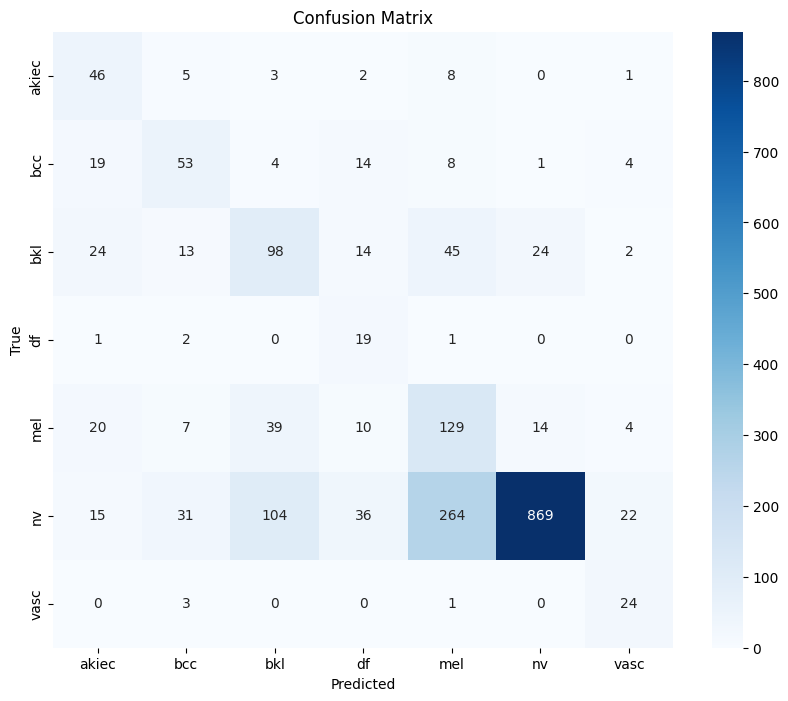

In [22]:
# true labels as indices
y_true = test_df['label_idx'].values

# get predictions (probabilities) for all test samples
pred_probs = model.predict(test_flow, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=label_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()

Plot training curves (accuracy & loss)

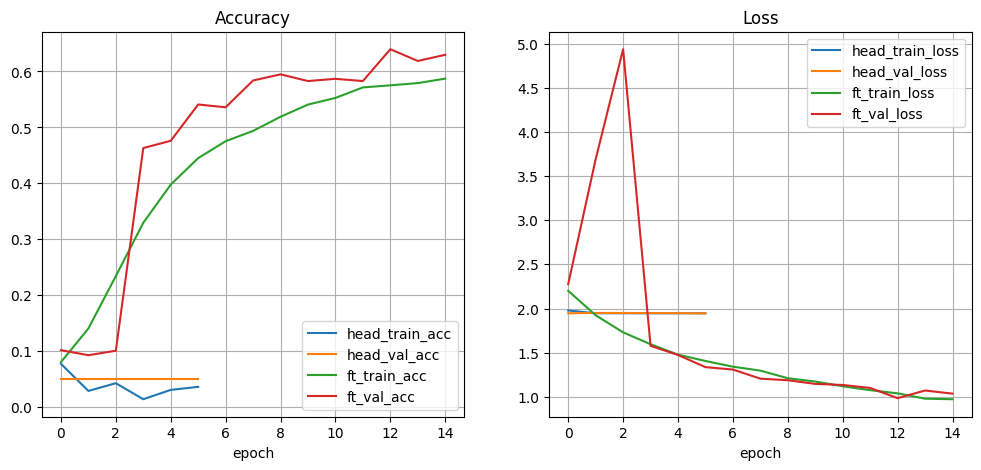

In [25]:
#Plot train/val curves for head training and fine-tune

def plot_history(h1, h2=None):
    plt.figure(figsize=(12,5))
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'], label='head_train_acc')
    plt.plot(h1.history['val_accuracy'], label='head_val_acc')
    if h2 is not None:
        plt.plot(h2.history['accuracy'], label='ft_train_acc')
        plt.plot(h2.history['val_accuracy'], label='ft_val_acc')
    plt.title('Accuracy'); plt.xlabel('epoch'); plt.legend(); plt.grid(True)

    # loss
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'], label='head_train_loss')
    plt.plot(h1.history['val_loss'], label='head_val_loss')
    if h2 is not None:
        plt.plot(h2.history['loss'], label='ft_train_loss')
        plt.plot(h2.history['val_loss'], label='ft_val_loss')
    plt.title('Loss'); plt.xlabel('epoch'); plt.legend(); plt.grid(True)

    plt.show()

plot_history(history_head, history_fine)

In [26]:
model.save(os.path.join(DATA_DIR, 'skin_effnetb0_best.h5'))
import json
with open(os.path.join(DATA_DIR, 'label_to_index.json'), 'w') as f:
    json.dump(label_to_index, f)
print("Saved model and label mapping to:", DATA_DIR)

Saved model and label mapping to: /content/drive/MyDrive/Projects/HAM10000


Saving ISIC_0031843.jpg to ISIC_0031843.jpg
ploaded image: ISIC_0031843.jpg


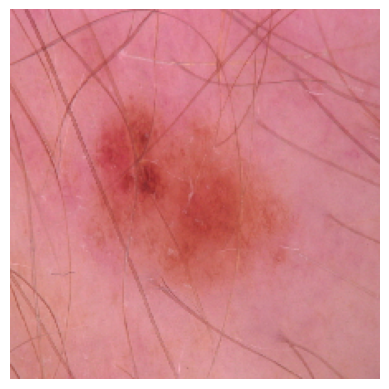

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
 Raw prediction vector: [[0.00166516 0.03375499 0.01929079 0.7021726  0.00552549 0.23476033
  0.00283065]]
 Predicted class index: 3
Predicted class: Dermatofibroma


In [30]:
from google.colab import files
from tensorflow.keras.preprocessing import image


uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    print(f"ploaded image: {img_path}")



IMG_SIZE = (224, 224)

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)

img_array = img_array / 255.0

img_array = np.expand_dims(img_array, axis=0)

plt.imshow(img)
plt.axis("off")
plt.show()


predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

print(f" Raw prediction vector: {predictions}")
print(f" Predicted class index: {predicted_class}")


labels_dict = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Vascular lesions',
    6: 'Melanoma'
}

print(f"Predicted class: {labels_dict[predicted_class]}")